In this kernel we shall look into the **Pima Indians Diabetes Database** dataset in which we shall predict possibilty of Diabetes given the different predictors. I have used 4 different classification algorithms namely:

* Logistic Regression
* KNearest Neighbours
* Support Vector Machines
* Random Forests Classifier

I have also used extensive Grid Search CV for hyperparameter tuning. Hope my notebook helps. 🤗🤗

Credits - https://www.kaggle.com/shrutimechlearn/step-by-step-diabetes-classification-knn-detailed

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [ ]:
df = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.describe()

We can see that the features are centered around different means(they are at different scales and magnitudes), so we shall need to scale them

In [ ]:
dfcopy = df.copy()
dfcopy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = dfcopy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [ ]:
# Dealing with missing data

In [ ]:
sns.heatmap(dfcopy.isnull(), cmap='Blues')

In [ ]:
df.hist(figsize = (20,20))
plt.show()

In [ ]:
dfcopy['Insulin'].fillna(dfcopy['Insulin'].median(), inplace=True)
dfcopy['Glucose'].fillna(dfcopy['Glucose'].mean(), inplace=True)
dfcopy['BMI'].fillna(dfcopy['BMI'].mean(), inplace=True)
dfcopy['BloodPressure'].fillna(dfcopy['BloodPressure'].mean(), inplace=True)
dfcopy['SkinThickness'].fillna(dfcopy['SkinThickness'].median(), inplace=True)

In [ ]:
dfcopy.head()

In [ ]:
dfcopy.hist(figsize = (20,20))
plt.show()

In [ ]:
sns.heatmap(df.corr(), cmap='Blues')

In [ ]:
sns.heatmap(dfcopy.corr(), cmap='Blues')

In [ ]:
col = 'Outcome'

In [ ]:
sns.scatterplot(x='Insulin', y='SkinThickness', data=df, hue=col)

In [ ]:
sns.scatterplot(x='Age', y='Pregnancies', data=df, hue=col)

In [ ]:
sns.countplot(df['Outcome'])

In [ ]:
sns.pairplot(dfcopy, hue='Outcome')

I have the used the Min Max scaler since it is more robust to outliers that the standard scaler.
![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQBfejbXDJOx5SaiPbWx6ShhAwARBUcWvTd8A&usqp=CAU)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
X =  pd.DataFrame(scaler.fit_transform(dfcopy.drop(["Outcome"],axis = 1),),
        columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'])

In [ ]:
X.head()

In [ ]:
y = dfcopy.Outcome

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

We had already seen that the representation of positive samples were much less than the negative once. Hence we shall use stratified sampling to split the dataset.
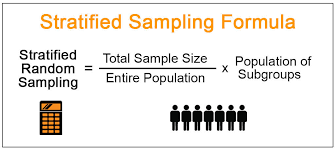

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)

1. Logistic Regresion

In [ ]:
model = LogisticRegression()
solvers = ['newton-cg', 'saga', 'liblinear']
penalty = ['l2', 'l1']
c_values = [5, 10, 1.0, 0.1, 0.01, 0.05]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=3, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
best_model1 = LogisticRegression(C=1.0, solver='newton-cg', penalty = 'l2')
best_model1.fit(X_train, y_train)
y_pred = best_model1.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve, classification_report

print(confusion_matrix(y_test, y_pred))
print('Accuracy of our model is: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
lr_acc = accuracy_score(y_test, y_pred)

In [ ]:
y_proba = best_model1.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

In [ ]:
plt.plot([0,1],[0,1],'--')
plt.plot(fpr,tpr, label='Log-Reg')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Logistic Regression ROC curve')
plt.show()

In [ ]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_proba)

2. KNN

In [ ]:
param_grid = {'n_neighbors':np.arange(1,20), 'algorithm':['auto', 'kd_tree', 'brute']}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=3)
knn_cv.fit(X_train, y_train)

In [ ]:
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

In [ ]:
best_model2 = KNeighborsClassifier(13)
best_model2.fit(X_train,y_train)
y_pred = best_model2.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred))
print('Accuracy of our model is: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
knn_acc = accuracy_score(y_test, y_pred)

In [ ]:
y_proba = best_model2.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
print(roc_auc_score(y_test,y_proba))

plt.plot([0,1],[0,1],'--')
plt.plot(fpr,tpr, label='KNN - 13')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('KNN ROC curve')
plt.show()

3. Random Forests Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier()

In [ ]:
n_estimators = [200, 300, 400, 500]
max_depth = [4,6,5,7, 8]
min_samples_split = [6,8,9,7,10]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split)

gridF = GridSearchCV(rf1, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

In [ ]:
# summarize results
print("Best: %f using %s" % (bestF.best_score_, bestF.best_params_))

In [ ]:
rf_best = RandomForestClassifier(max_depth= 7, min_samples_split= 10, n_estimators= 400)
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy of our model is: ', accuracy_score(y_test, y_pred))

In [ ]:
rf_acc = accuracy_score(y_test, y_pred)

In [ ]:
importance = rf_best.feature_importances_
indices = np.argsort(importance)[::-1]
feature_names = X.columns # e.g. ['A', 'B', 'C', 'D', 'E']

f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importance[indices],
    color="b", 
    align="center")
plt.xticks(range(X.shape[1]), feature_names ,rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)

4. Support vector Classifiers

In [ ]:
from sklearn.svm import SVC
# defining parameter range 
param_grid = {'C': [100, 50, 75], 
            'gamma': [ 0.1,0.5, 0.01, 0.001], 
            'kernel': ['linear','rbf', 'poly','sigmoid']} 

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv=3) 

# fitting the model for grid search 
grid.fit(X_train, y_train) 

In [ ]:
# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

In [ ]:
svc = SVC(C=100, gamma=0.1)
svc.fit(X_train,y_train)

In [ ]:
y_pred = svc.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy of our model is: ', accuracy_score(y_test, y_pred))

In [ ]:
svc_acc = accuracy_score(y_test, y_pred)

In [ ]:
m1 = 'Logistic Regression'
m2 = 'K Nearest Neighbours'
m3 = 'Random Forests'
m4 = 'Support Vector Classifiers'

In [ ]:
colors = ["orange", "green", "magenta", "red"]
acc = [lr_acc,knn_acc,rf_acc, svc_acc]
m = [m1,m2,m3, m4]
plt.figure(figsize=(10,5))
plt.yticks(np.arange(0,100,10))
plt.title("barplot Represent Accuracy of different models")
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot( y=acc,x=m, palette=colors)
plt.show()